<a href="https://colab.research.google.com/github/nissrinayy/deeplearning/blob/main/Week5/LSTM_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM Model PyTorch : ReviewTokoBaju.csv Dataset😶‍🌫️**

LSTM adalah jenis RNN yang lebih canggih dan dirancang untuk mengatasi masalah vanishing gradient dengan menggunakan tiga gerbang utama: gerbang input (input gate), gerbang lupa (forget gate), dan gerbang output (output gate). Gerbang-gerbang ini membantu LSTM untuk mengingat informasi dalam jangka panjang dan membuang informasi yang tidak relevan. LSTM sangat efektif dalam menangani masalah ketergantungan jangka panjang.

In [1]:
import pandas as pd
import re
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


In [2]:
# Load the dataset
file_path = '/content/ReviewTokoBaju.csv'
data = pd.read_csv(file_path)

## PreProcessing

In [3]:
# Preprocessing function to clean the text
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text


In [4]:
# Clean the Review Text column
data['cleaned_review'] = data['Review Text'].apply(lambda x: clean_text(str(x)))


In [5]:
# Filter out rows where the Review Text is missing
data = data.dropna(subset=['cleaned_review'])


In [6]:
# Extract features and target
X = data['cleaned_review'].values
y = data['Recommended IND'].values


In [7]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Convert text to numerical format using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()


In [9]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_tfidf, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [10]:
# Create DataLoader for batching
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)


In [11]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [12]:
# Check the shape of the prepared data
print(X_train_tfidf.shape, X_test_tfidf.shape)

(18788, 5000) (4698, 5000)


## Build LSTM Model

In [13]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Passing input through LSTM layer
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Get the output of the last timestep
        out = self.fc(out)  # Output to fully connected layer
        return out

In [15]:
import numpy as np

# Define model parameters
input_size = X_train_tensor.shape[1]  # Number of features in input
hidden_size = 64
num_layers = 2
num_classes = len(np.unique(y_train))  # Number of output classes (0 or 1)
learning_rate = 0.001
num_epochs = 20


In [16]:
# Model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, num_classes)
criterion = torch.nn.CrossEntropyLoss()  # For classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training Model

In [19]:
# Reshape X_train_tensor and X_test_tensor to have 3 dimensions
X_train_tensor = X_train_tensor.unsqueeze(1)  # Add sequence dimension (1)
X_test_tensor = X_test_tensor.unsqueeze(1)    # Add sequence dimension (1)


In [20]:
# Training Loop
train_losses = []
test_losses = []

In [21]:
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        test_losses.append(test_loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

Epoch [1/20], Train Loss: 0.6651, Test Loss: 0.6625
Epoch [2/20], Train Loss: 0.6621, Test Loss: 0.6596
Epoch [3/20], Train Loss: 0.6591, Test Loss: 0.6567
Epoch [4/20], Train Loss: 0.6562, Test Loss: 0.6537
Epoch [5/20], Train Loss: 0.6532, Test Loss: 0.6508
Epoch [6/20], Train Loss: 0.6502, Test Loss: 0.6478
Epoch [7/20], Train Loss: 0.6472, Test Loss: 0.6448
Epoch [8/20], Train Loss: 0.6442, Test Loss: 0.6418
Epoch [9/20], Train Loss: 0.6411, Test Loss: 0.6387
Epoch [10/20], Train Loss: 0.6379, Test Loss: 0.6355
Epoch [11/20], Train Loss: 0.6347, Test Loss: 0.6323
Epoch [12/20], Train Loss: 0.6314, Test Loss: 0.6289
Epoch [13/20], Train Loss: 0.6280, Test Loss: 0.6255
Epoch [14/20], Train Loss: 0.6245, Test Loss: 0.6219
Epoch [15/20], Train Loss: 0.6209, Test Loss: 0.6182
Epoch [16/20], Train Loss: 0.6171, Test Loss: 0.6144
Epoch [17/20], Train Loss: 0.6132, Test Loss: 0.6104
Epoch [18/20], Train Loss: 0.6092, Test Loss: 0.6062
Epoch [19/20], Train Loss: 0.6050, Test Loss: 0.6019
Ep

In [22]:
# Predicting on test set
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predicted_classes = torch.argmax(predictions, dim=1)


In [23]:
# Metrics Calculation
accuracy = accuracy_score(y_test, predicted_classes)
precision = precision_score(y_test, predicted_classes, average='weighted')
recall = recall_score(y_test, predicted_classes, average='weighted')
f1 = f1_score(y_test, predicted_classes, average='weighted')
roc_auc = roc_auc_score(y_test, predicted_classes)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
# Confusion Matrix
cm = confusion_matrix(y_test, predicted_classes)


In [25]:
# Printing metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")

Accuracy: 0.8189
Precision: 0.6705
Recall: 0.8189
F1 Score: 0.7373
AUC: 0.5000


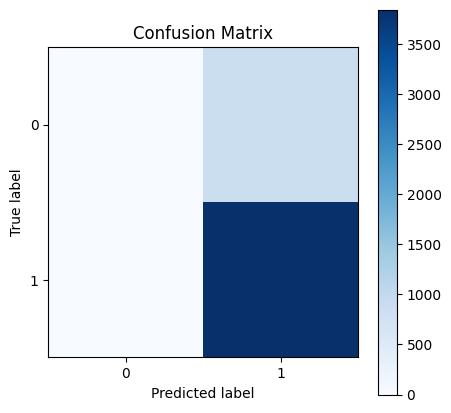

In [27]:
# Confusion Matrix Plot
fig, ax = plt.subplots(figsize=(5,5))
cax = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title("Confusion Matrix")
plt.colorbar(cax)  # Add colorbar to the image (cax)
tick_marks = np.arange(2)
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels([0, 1])
ax.set_yticklabels([0, 1])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


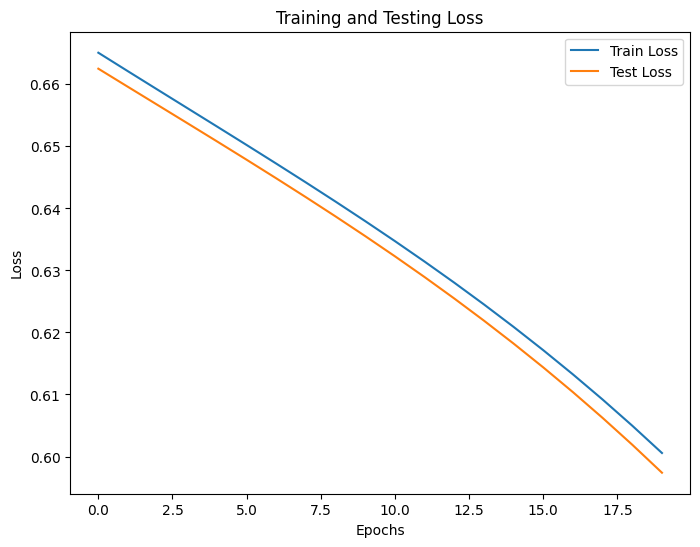

In [28]:
# Plotting Train and Test Loss
plt.figure(figsize=(8,6))
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()


#**Penjelasan Singkat**

1️⃣ Akurasi (Accuracy)

Akurasi mengukur seberapa banyak prediksi yang benar dibandingkan dengan total prediksi.


Akurasi=

*TP+TN/
TP+TN+FP+FN*
​

📌 Keterangan:

TP (True Positive) → Prediksi benar sebagai positif.

TN (True Negative) → Prediksi benar sebagai negatif.

FP (False Positive) → Prediksi salah sebagai positif.

FN (False Negative) → Prediksi salah sebagai negatif.


2️⃣ Presisi (Precision)

Presisi mengukur seberapa akurat model dalam memprediksi kelas positif.

Presisi=
*TP/
TP+FP*



📌 Keterangan:

Jika model memiliki presisi tinggi, berarti model jarang salah dalam memprediksi kelas positif.

Jika presisi rendah, model sering salah memprediksi negatif sebagai positif (False Positive tinggi).

3️⃣ Recall (Sensitivitas)

Recall mengukur seberapa baik model dalam menangkap semua kasus positif.

Recall=
*TP/
TP+FN*


📌 Keterangan:

Jika recall tinggi, berarti model berhasil menangkap hampir semua data positif.
Jika recall rendah, model sering gagal mengenali positif sebagai negatif (False Negative tinggi).

4️⃣ F1-Score (Harmonic Mean)
F1-score menggabungkan presisi dan recall dalam satu metrik menggunakan rata-rata harmonik.

𝐹
1
=
2
×
Presisi
×
Recall/
Presisi
+
Recall

📌 Keterangan:

F1-score tinggi berarti model seimbang dalam presisi dan recall.

Bagus untuk dataset tidak seimbang, karena mempertimbangkan False Positive dan False Negative secara bersamaan.

5️⃣ Area Under Curve (AUC - ROC)
AUC (Area Under Curve) mengukur seberapa baik model membedakan antara kelas positif dan negatif.

AUC berasal dari ROC Curve, yang membandingkan True Positive Rate (TPR) vs False Positive Rate (FPR).

TPR
=
𝑇
𝑃/
𝑇
𝑃
+
𝐹
𝑁

(Sama dengan Recall)

*FPR=
FP/
FP+TN*

📌 Keterangan:

AUC = 1.0 → Model sempurna (memisahkan kelas dengan sempurna).
AUC = 0.5 → Model acak (tidak lebih baik dari tebak-tebakan).
AUC < 0.5 → Model lebih buruk dari acak (terbalik).

6️⃣ Receiver Operating Characteristic (ROC) Curve

ROC Curve adalah grafik yang membandingkan TPR vs FPR pada berbagai threshold.


Sumbu X → FPR (False Positive Rate)

Sumbu Y → TPR (True Positive Rate / Recall)

📌 Bagaimana membacanya?


Semakin tinggi kurva, semakin baik model.

ROC yang mendekati diagonal (AUC ≈ 0.5) berarti model tidak berguna.